# Configuración spark

In [1]:
# Instala Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Descargar Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xvzf spark-3.5.0-bin-hadoop3.tgz

spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/py_container_checks.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning_cleanup.py
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/decom.sh
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/python/
spark-3.5.0-bin-hadoop3/kubern

In [3]:
# Instala findspark (facilita la integración con notebooks)
!pip install -q findspark

In [4]:
# Variables de entorno:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [5]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [7]:
path_datos = "/content/drive/MyDrive/TFM/datos"

# Librerias

In [8]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F

# from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Lectura de datos

In [9]:
datos_financieros = spark.read.parquet(f"{path_datos}/datos_financieros_amzn_cleaned_19_25")
datos_noticias = spark.read.parquet(f"{path_datos}/datos_noticias_cleaned_19_25").drop("target")

In [10]:
datos_completo = datos_financieros.join(datos_noticias, "date", "left")

In [11]:
df_completo = datos_completo.toPandas().sort_values("date").reset_index(drop=True)

In [12]:
len(df_completo)

1510

In [13]:
len(df_completo.columns)

139

In [14]:
datos_completo.groupBy("target").count().withColumn("pct", F.col("count") / datos_completo.count()).show()

+------+-----+------------------+
|target|count|               pct|
+------+-----+------------------+
|     1|  505|0.3344370860927152|
|     0| 1005|0.6655629139072847|
+------+-----+------------------+



In [15]:
datos_completo.groupBy("target","ind_existencia_noticias").count().withColumn("pct", F.col("count") / datos_noticias.count()).show()

+------+-----------------------+-----+--------------------+
|target|ind_existencia_noticias|count|                 pct|
+------+-----------------------+-----+--------------------+
|     1|                      0|   29|0.019205298013245033|
|     1|                      1|  476|  0.3152317880794702|
|     0|                      0|   56| 0.03708609271523179|
|     0|                      1|  949|   0.628476821192053|
+------+-----------------------+-----+--------------------+



# Tratamiento

In [16]:
# Identificamos las variables input
vars_input = [var for var in df_completo.columns if var not in ["date","target"]]

In [17]:
# Parámetros:
w_size = 20

In [18]:
# Escalamos las variables input teniendo en cuenta únicamente los datos pasados
# Usamos la técnica rolling min-max
df_completo_trat = df_completo.copy()
for var in vars_input:
  v_unique = {"day_of_week": 7, "month": 12, "week_of_year": 53, "day_of_month": 31}
  vars_binarias = ["cross_ma_10d_vs_20d", "cross_ma_20d_vs_50d", "cross_ma_50d_vs_100d", "cross_ma_100d_vs_200d"]
  vars_noticias = datos_noticias.drop("date").columns

  if var in v_unique:
    # Escalado de variables cíclicas:
    df_completo_trat[f"{var}_sin"] = np.sin(2 * np.pi * df_completo_trat[var]/v_unique[var])
    df_completo_trat[f"{var}_cos"] = np.cos(2 * np.pi * df_completo_trat[var]/v_unique[var])
    df_completo_trat = df_completo_trat.drop(var, axis=1)
  elif var not in vars_binarias + vars_noticias:
    # Aplicamos un RobustScaler:
    median_w = df_completo_trat[var].rolling(w_size).median()
    p75_w = df_completo_trat[var].rolling(w_size).quantile(0.75)
    p25_w = df_completo_trat[var].rolling(w_size).quantile(0.25)
    iqr_w = p75_w - p25_w
    df_completo_trat[var] = (df_completo_trat[var] - median_w) / iqr_w

# Como los primeros w_size registros no tendrán suficientes datos, los eliminamos:
df_completo_trat = df_completo_trat.iloc[w_size:].reset_index(drop = True)

In [19]:
print(df_completo_trat.isna().sum().sum())

0


In [20]:
vars_input_trat = [var for var in df_completo_trat.columns if var not in ["date","target"]]

In [21]:
# Primero separamos en train y test:
# Para evitar leakage temporal, debemos revisar que no incluyamos datos del test en en el entrenamiento
# Además, debemos asegurar el orden temporal:
train_size = int(0.8 * len(df_completo_trat))
X = []
y = []
ind_noticias = []

# 1- Calculamos las ventanas temporales
for i in range(w_size, len(df_completo_trat)):
    X.append(df_completo_trat.iloc[i - w_size:i, :][vars_input_trat].values)
    y.append(df_completo_trat.iloc[i]['target'])
    ind_noticias.append(df_completo_trat.iloc[i]["ind_existencia_noticias"])

X = np.array(X)
y = np.array(y)

# 2- Separamos en train y test
X_train, X_test = X[:train_size - w_size], X[train_size - w_size:]
y_train, y_test = y[:train_size - w_size], y[train_size - w_size:]

ind_noticias_train = ind_noticias[:train_size - w_size]

In [22]:
X_train.shape

(1172, 20, 141)

In [23]:
X_test.shape

(298, 20, 141)

In [24]:
len(df_completo_trat)

1490

In [25]:
X.shape

(1470, 20, 141)

In [26]:
# Revisamos el escalado:
np.max(X_train), np.min(X_train)

(np.float64(283.6808467964895), np.float64(-85.83785676956177))

# Entrenamiento

In [27]:
def lstm_model(input_shape):
  model = Sequential([Input(shape=input_shape),
                      LSTM(64, return_sequences=True),
                      Dropout(0.3),
                      LSTM(32),
                      Dense(64, activation='relu'),
                      Dropout(0.3),
                      Dense(1, activation='sigmoid')])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall(), Precision(), 'AUC'])
  return model

In [28]:
n_cols = len(vars_input_trat)

base_model = lstm_model(input_shape=(w_size, n_cols))
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        52,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,329 (263.00 KB)

 Trainable params: 67,329 (263.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Aplicamos peso a las clases para balancear:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = dict(enumerate(class_weights))

In [41]:
# Pesos del target:
weights_clase = np.array([class_weights[y] for y in y_train])

# Peso de los casos con noticias:
weight_for_news = 1.0
weight_for_no_news = 0.75

weights_noticias = tf.where(ind_noticias == 1,
                              weight_for_news,
                              weight_for_no_news)
weights_noticias_np = weights_noticias.numpy() if hasattr(weights_noticias, "numpy") else weights_noticias

# Peso final:
weights_final = weights_clase * weights_noticias_np

In [43]:
early_stop_param = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_loss")

model_history = base_model.fit(X_train, y_train,
                               validation_split = 0.2,
                               epochs=50,
                               batch_size=32,
                               callbacks=[early_stop_param],
                               verbose = 1,
                               sample_weight = weights_final)
                              #  class_weight=class_weights)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.6227 - loss: 0.5058 - precision: 0.4657 - recall: 0.3293 - val_AUC: 0.4442 - val_loss: 0.5390 - val_precision: 0.2920 - val_recall: 0.3929
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.6749 - loss: 0.5003 - precision: 0.4907 - recall: 0.5486 - val_AUC: 0.4494 - val_loss: 0.5501 - val_precision: 0.3023 - val_recall: 0.3095
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.6950 - loss: 0.4941 - precision: 0.5276 - recall: 0.5785 - val_AUC: 0.4709 - val_loss: 0.5636 - val_precision: 0.2970 - val_recall: 0.3571
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - AUC: 0.7350 - loss: 0.4543 - precision: 0.5521 - recall: 0.5926 - val_AUC: 0.4676 - val_loss: 0.6233 - val_precision: 0.3494 - val_recall: 0.3452
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - AUC: 0.7497 - loss: 0.4400 - precision: 0.5381 - recall: 0.6259 - val_AUC: 0.4732 - val_loss: 0.6176 - val_precision: 0.3152 - val_recall: 0.3452
Epoch

## Evaluación del modelo

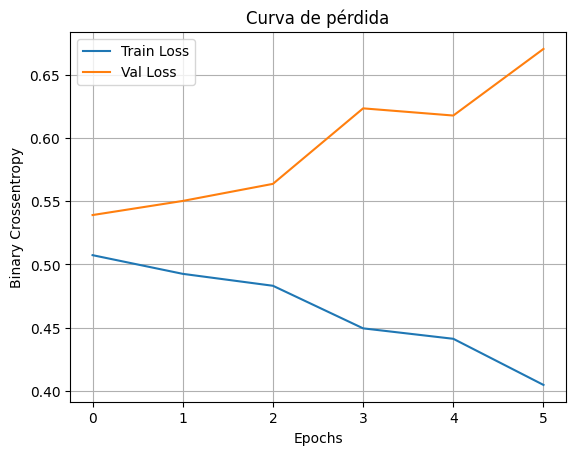

In [44]:
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title("Curva de pérdida")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
base_model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5483 - loss: 0.6931 - precision: 0.3623 - recall: 0.4644


[0.6946078538894653,
 0.5545454621315002,
 0.3742331266403198,
 0.5316247344017029]

In [46]:
loss_resultado, recall_resultado, prec_resultado, auc_resultado = base_model.evaluate(X_test, y_test)
print(f"Test Recall: {recall_resultado:.4f}")
print(f"Test Precision: {prec_resultado:.4f}")
print(f"Test AUC: {auc_resultado:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5483 - loss: 0.6931 - precision: 0.3623 - recall: 0.4644
Test Recall: 0.5545
Test Precision: 0.3742
Test AUC: 0.5316


In [47]:
y_pred_prob = base_model.predict(X_test)
y_pred = (y_pred_prob > 0.47).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[ 20 168]
 [  5 105]]
              precision    recall  f1-score   support

           0       0.80      0.11      0.19       188
           1       0.38      0.95      0.55       110

    accuracy                           0.42       298
   macro avg       0.59      0.53      0.37       298
weighted avg       0.65      0.42      0.32       298

AUC: 0.5326402321083172


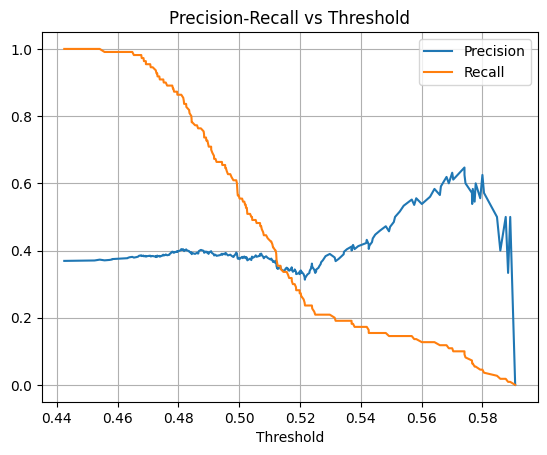

In [48]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid(True)
plt.show()